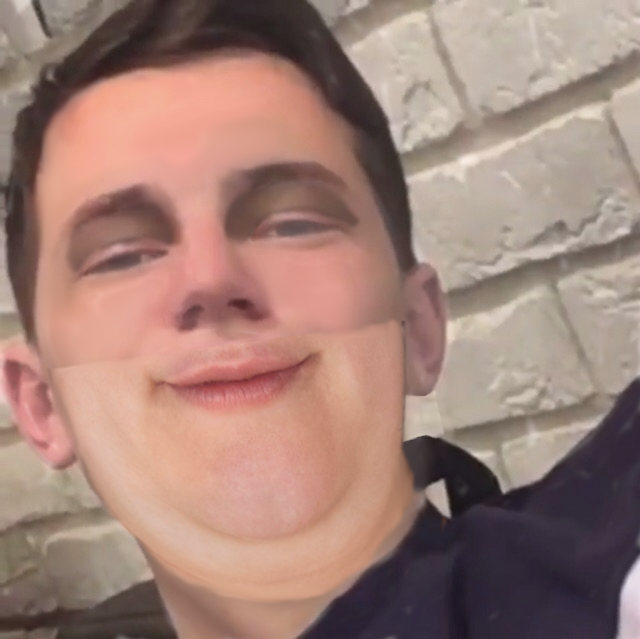

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!pip install -U keras-tuner

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [ ]:
import keras
from kerastuner.tuners import Hyperband
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Dropout
import IPython
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/train.csv")

In [ ]:
data.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
del data['ID']

In [ ]:
data[data.columns] = SimpleImputer(strategy="most_frequent").fit_transform(data[data.columns])
data.head()

,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,130.81,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,76.26,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,80.62,az,t,n,f,d,x,l,e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,78.02,az,v,n,f,d,h,d,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
data.head()

,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,130.81,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,76.26,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,80.62,az,t,n,f,d,x,l,e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,78.02,az,v,n,f,d,h,d,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
col = data.select_dtypes(include=[object])
data.loc[:, col.columns] = col.apply(LabelEncoder().fit_transform)

In [ ]:
data.head()

,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,130.81,32,23,17,0,3,24,9,14,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,88.53,32,21,19,4,3,28,11,14,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,76.26,20,24,34,2,3,27,9,23,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,80.62,20,21,34,5,3,27,11,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,78.02,20,23,34,5,3,12,3,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# data_norm = (data - data.mean()) / data.std()
data_norm = data
data_norm.head()

,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,130.81,32,23,17,0,3,24,9,14,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,88.53,32,21,19,4,3,28,11,14,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,76.26,20,24,34,2,3,27,9,23,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,80.62,20,21,34,5,3,27,11,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,78.02,20,23,34,5,3,12,3,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
split = 0.7
seed = 200

In [ ]:
y_data = data_norm.get('y')
x_data = data_norm.drop('y' , axis=1)

In [ ]:
x_train = x_data.sample(frac=split, random_state=seed)
x_test = x_data.drop(x_train.index)

y_train = y_data.sample(frac=split, random_state=seed)
y_test = y_data.drop(y_train.index)

In [ ]:
x_train.head()

,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
3191,36,22,16,2,3,23,6,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2378,40,3,33,2,3,18,6,13,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3410,21,1,7,6,3,22,11,16,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1185,35,13,3,5,3,1,8,14,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1309,46,19,3,2,0,2,0,18,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
y_train.head()

3191    95.65
2378    92.38
3410    89.06
1185    88.92
1309    96.69
Name: y, dtype: float64

In [ ]:
def build_model(hp):
  activation_choice = hp.Choice('activation', values=['relu', 'sigmoid', 'tanh', 'elu', 'selu'])
  hidden_layers_choice = hp.Choice('hidden_layers', values=[0, 1, 2, 3])

  model = Sequential()
  model.add(Dense(377, activation="relu", input_shape=(x_train.shape[1],)))
  model.add(
      Dense(
          units=hp.Int(
              'input_units',
              min_value=128, 
              max_value=256, 
              step=16,
          ), 
          input_dim=x_train.shape[1], 
          activation=activation_choice,
      ),
  )
  model.add(Dropout(0.25))
  for i in range(hidden_layers_choice):
    model.add(
        Dense(
            units=hp.Int(
                f'layer_{i + 1}_units',
                min_value=2 // (i + 1),
                max_value=128 // (i + 1),
                step=14 // (i + 1),
            ),
            activation=activation_choice
        )
    )
  model.add(Dense(1))

  model.compile(
      optimizer='adam', 
      loss='mae',
      metrics=['mae'], 
  )

  return model

In [ ]:
tuner = Hyperband(
    build_model,
    objective='mae', 
    max_epochs=10,
    directory='models',
    project_name='lab1',
)

INFO:tensorflow:Reloading Oracle from existing project models/lab1/oracle.json
INFO:tensorflow:Reloading Tuner from models/lab1/tuner0.json


In [ ]:
tuner.search_space_summary()

In [ ]:
class ClearTrainingOutput(Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
tuner.search(
    x_train,
    y_train,
    validation_split=0.2,
    verbose=2,
    callbacks = [ClearTrainingOutput()],
)

INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 377)               142129    
_________________________________________________________________
dense_1 (Dense)              (None, 240)               90720     
_________________________________________________________________
dropout (Dropout)            (None, 240)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               24100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 257,050
Trainable params: 257,050
Non-trainable params: 0
_________________________________________________________________


In [ ]:
fit_history = model.fit(x_train, y_train, epochs=15, batch_size=64, validation_split=0.2, verbose=2)

Epoch 1/15
37/37 - 0s - loss: 29.7257 - mae: 29.7257 - val_loss: 11.0891 - val_mae: 11.0891
Epoch 2/15
37/37 - 0s - loss: 10.4324 - mae: 10.4324 - val_loss: 7.5049 - val_mae: 7.5049
Epoch 3/15
37/37 - 0s - loss: 7.8672 - mae: 7.8672 - val_loss: 6.3938 - val_mae: 6.3938
Epoch 4/15
37/37 - 0s - loss: 7.2300 - mae: 7.2300 - val_loss: 5.4740 - val_mae: 5.4740
Epoch 5/15
37/37 - 0s - loss: 6.6098 - mae: 6.6098 - val_loss: 5.2052 - val_mae: 5.2052
Epoch 6/15
37/37 - 0s - loss: 6.2943 - mae: 6.2943 - val_loss: 5.6867 - val_mae: 5.6867
Epoch 7/15
37/37 - 0s - loss: 6.2918 - mae: 6.2918 - val_loss: 5.0822 - val_mae: 5.0822
Epoch 8/15
37/37 - 0s - loss: 6.2906 - mae: 6.2906 - val_loss: 5.6932 - val_mae: 5.6932
Epoch 9/15
37/37 - 0s - loss: 6.0972 - mae: 6.0972 - val_loss: 4.9908 - val_mae: 4.9908
Epoch 10/15
37/37 - 0s - loss: 6.1006 - mae: 6.1006 - val_loss: 4.9483 - val_mae: 4.9483
Epoch 11/15
37/37 - 0s - loss: 6.1363 - mae: 6.1363 - val_loss: 4.9171 - val_mae: 4.9171
Epoch 12/15
37/37 - 0s -

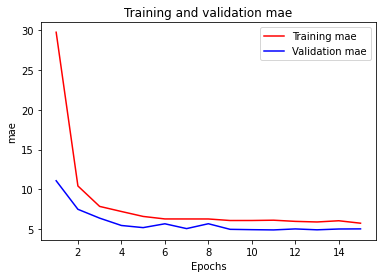

In [ ]:
history = fit_history.history
epochs = range(1, len(history['loss']) + 1)
mae = history['mae']
val_mae = history['val_mae']
plt.plot(epochs, mae, 'r', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

In [ ]:
results = model.evaluate(x_test, y_test, verbose=0)
print('test loss, test acc:', results)

test loss, test acc: [5.54748010635376, 5.54748010635376]


In [ ]:
pred = model.predict(x_test)
pred

array([[ 81.74434],
       [104.48539],
       [ 91.39675],
       ...,
       [ 95.37642],
       [ 93.81668],
       [ 96.27915]], dtype=float32)

In [ ]:
print('размерность прогнозов:', pred.shape)

размерность прогнозов: (1263, 1)


In [ ]:
print('размерность y:', y_test.shape)

размерность y: (1263,)


In [ ]:
pred_1 = pred
pred_1.shape = y_test.shape

In [ ]:
np.corrcoef(pred, y_test)

array([[1.        , 0.75237048],
       [0.75237048, 1.        ]])

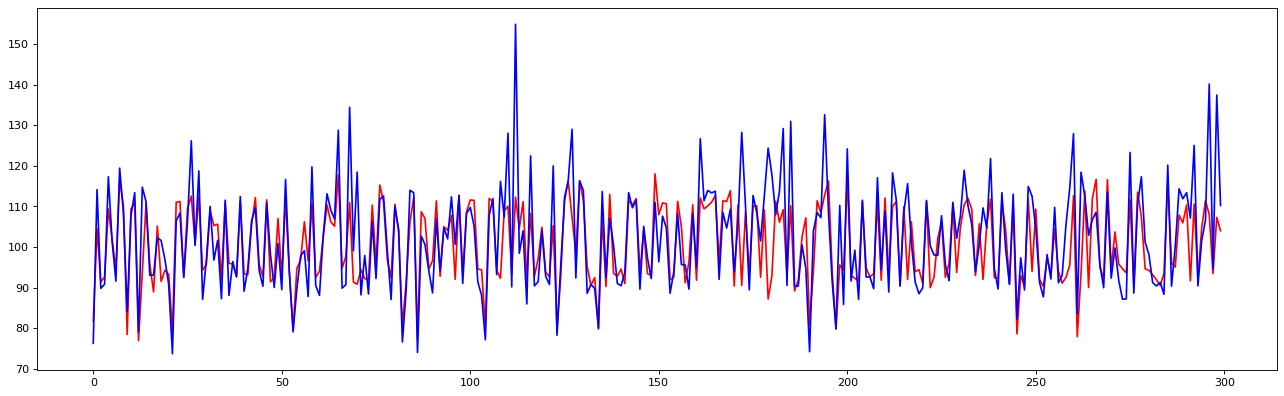

In [ ]:
from matplotlib.pyplot import figure
size = 300
figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.arange(size), pred_1[:size], color='r')
plt.plot(np.arange(size), y_test[:size], color='b')
plt.show()